# Low-Rank Sinkhorn

We experiment with the low-rank (LR) Sinkhorn solver, proposed by <cite data-cite="scetbon:21">Scetbon et al.</cite> as an alternative to the Sinkhorn algorithm. 

The idea of that solver is to compute optimal transport couplings that are low-rank, by design. Rather than look for a $n\times m$ matrix $P_\varepsilon$ that has a factorization $D(u)\exp(-C/\varepsilon)D(v)$ (as computed by the Sinkhorn algorithm) when solving a problem with cost $C$, the set of feasible plans is restricted to those adopting a factorization of the form $P_r = Q D(1/g) R^T$, where $Q$ is $n\times r$, $R$ is $r \times m$ are two thin matrices, and $g$ is a $r$-dimensional probability vector.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax.numpy as jnp
import jax
import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 18})

In [3]:
def create_points(rng, n, m, d):
    rngs = jax.random.split(rng, 4)
    x = jax.random.normal(rngs[0], (n, d)) + 1
    y = jax.random.uniform(rngs[1], (m, d))
    a = jax.random.uniform(rngs[2], (n,))
    b = jax.random.uniform(rngs[3], (m,))
    a = a / jnp.sum(a)
    b = b / jnp.sum(b)
    return x, y, a, b

Create an OT problem comparing two point clouds


In [4]:
rng = jax.random.PRNGKey(0)
n, m, d = 19, 35, 2
x, y, a, b = create_points(rng, n=n, m=m, d=d)

geom = pointcloud.PointCloud(x, y, epsilon=0.1)
ot_prob = linear_problem.LinearProblem(geom, a, b)

## Solve it with Sinkhorn and plot plan/map

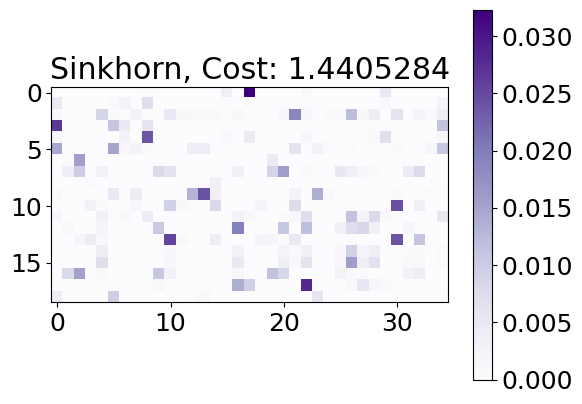

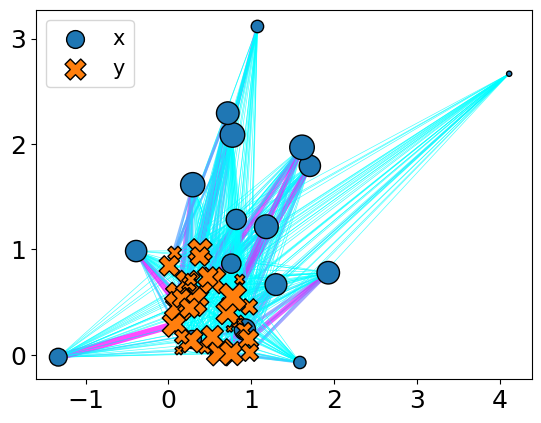

In [5]:
solver = sinkhorn.Sinkhorn()
ot_sink = solver(ot_prob)

transp_cost = jnp.sum(ot_sink.matrix * geom.cost_matrix)
plt.imshow(ot_sink.matrix, cmap="Purples")
plt.title("Sinkhorn, Cost: " + str(transp_cost))
plt.colorbar()
plt.show()
plott = ott.tools.plot.Plot()
_ = plott(ot_sink)

## Experimentations with the Low-Rank approach
Solve that problem using the Low-Rank Sinkhorn solver, with a rank parameterized to be equal to the half of $r=\min(n,m)/2$

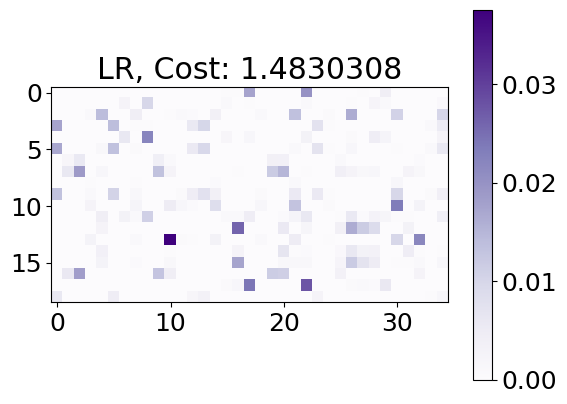

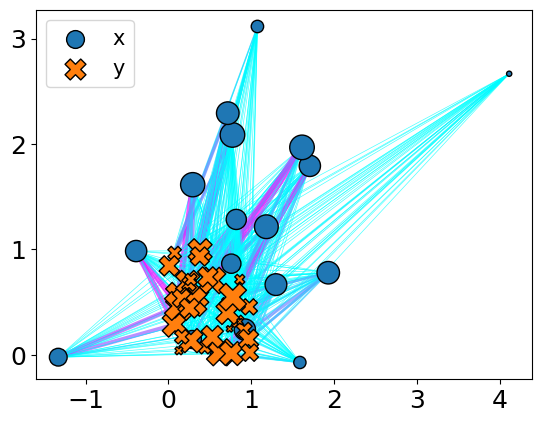

In [6]:
solver = sinkhorn_lr.LRSinkhorn(rank=int(min(n, m) / 2))
ot_lr = solver(ot_prob)

transp_cost = ot_lr.compute_reg_ot_cost(ot_prob)
plt.imshow(ot_lr.matrix, cmap="Purples")
plt.colorbar()
plt.title("LR, Cost: " + str(transp_cost))
plt.show()
plott = ott.tools.plot.Plot()
_ = plott(ot_lr)

## Play with larger scales
One of the interesting features of the low-rank approach lies in its ability to scale, since its iterations are of complexity $O( (n+m) r)$ rather than $O(nm)$. We consider this by sampling two points clouds of size 100 000 in $d=7$. 

In [7]:
n, m, d = 10**5, 10**5 + 1, 7
x, y, a, b = create_points(rng, n=n, m=m, d=d)

We compute plans satisfy a rank constraint $r$, for various values of $r$,

In [8]:
geom = pointcloud.PointCloud(x, y, epsilon=0.1)
ot_prob = linear_problem.LinearProblem(geom, a, b)
costs = []
ranks = [15, 20, 35, 50, 100]
for rank in ranks:
    solver = sinkhorn_lr.LRSinkhorn(rank=rank, initializer="k-means")
    ot_lr = solver(ot_prob)
    costs.append(ot_lr.reg_ot_cost)

As expected, the optimal cost decreases with rank, as shown in the plot below. Recall that, because of the non-convexity of the original problem, there may be small bumps along the way. 

For these two fairly concentrated distributions, it seems possible to produce plans that have relatively small rank yet low cost.

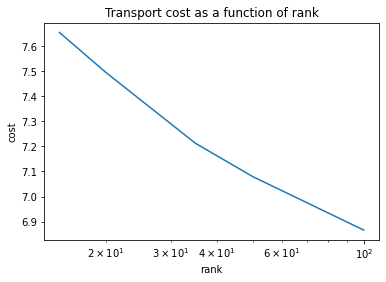

In [9]:
plt.plot(ranks, costs)
plt.xscale("log")
plt.xlabel("rank")
plt.ylabel("cost")
plt.title("Transport cost as a function of rank")
plt.show()